In [14]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import sys

sys.path.append("incl/")

import ELPH_dyn
import ELPH_utils


#global hyperparameters
kmax = 4.
n_kmax = 120


# init = ELPH_dyn.get_init_cond_gauss(kmax = kmax, n_kmax = n_kmax, max_pos = 0.15, width = 0.05, density=density)
# plt.plot(init[:n_kmax])
# plt.show()

# nkdyn = ELPH_dyn.get_el_dynamics(init, n_kmax = n_kmax)
# plt.imshow(nkdyn, aspect='auto')
# plt.colorbar()
# plt.show()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
n_runs = 10

paras = np.zeros((n_runs,3))

paras[:,0] = np.linspace(0.1,0.7,n_runs) #max_pos
paras[:,1] = 0.05 #width
paras[:,2] = 0.1 #density

runs = ELPH_utils.get_runs_gaussian_init(kmax, n_kmax, paras)


runs[0] shape:  (120, 2000)


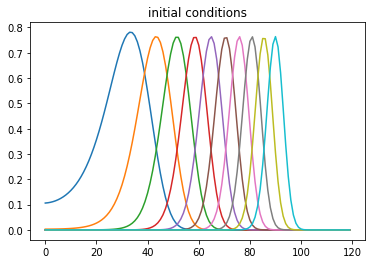

In [16]:
# plt.imshow(runs[1], aspect='auto')
# plt.colorbar()
# plt.show()

print('runs[0] shape: ', runs[0].shape)

for k in range(n_runs):
    plt.plot(runs[k][:,0])

plt.title('initial conditions')
plt.show()

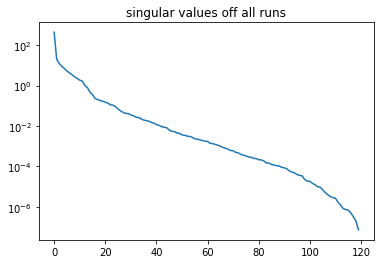

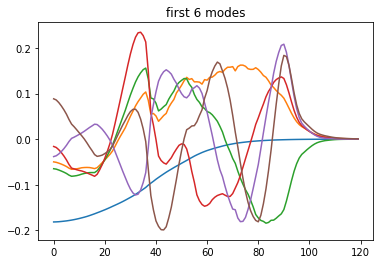

reduced coefficient matrix shape:  (6, 20000)


In [17]:

U,S = ELPH_utils.get_SVD_from_runs(runs)

plt.semilogy(S)
plt.title('singular values off all runs')
plt.show()

rdim = 6

for l in range(rdim):
  plt.plot(U[:,l], label='Uhat_'+str(l))
plt.title('first ' + str(rdim) + ' modes')
plt.show()


cmat = ELPH_utils.get_reduced_coef_matrix(runs, U, rdim)

print('reduced coefficient matrix shape: ', cmat.shape)
    
scmat, mean, std = ELPH_utils.standardize_data_matrix(cmat)

coef_runs = ELPH_utils.get_coef_runs(scmat, n_runs)

state shape:  (18, 19970)
target shape: (6, 19970)


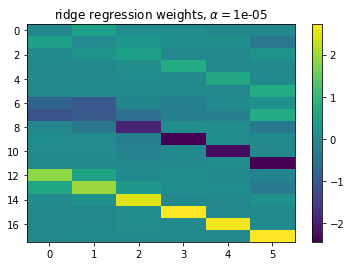

In [18]:
import ELPH_VAR

n_VAR_steps = 3

state,target = ELPH_VAR.build_VAR_training_matrices(coef_runs, n_VAR_steps)

print('state shape: ', state.shape)
print('target shape:', target.shape)


alpha = 1e-5
w = ELPH_utils.get_ridge_regression_weights(state, target, alpha)

plt.imshow(w, aspect='auto', interpolation='none')
plt.title('ridge regression weights, ' + r'$\alpha = $' + str(alpha) )
plt.colorbar()
plt.show()

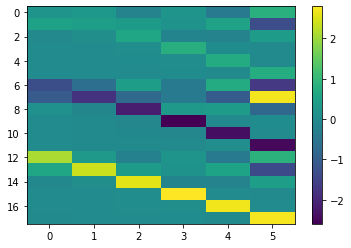

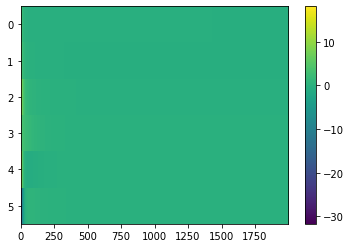

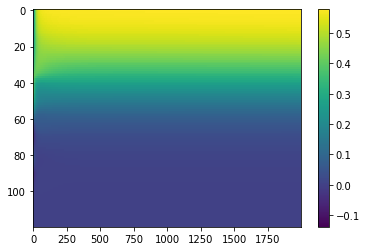

In [19]:

model = ELPH_VAR.VAR(coef_runs, n_VAR_steps = 3)
model.train()

plt.imshow(model.w, aspect='auto', interpolation='none')
plt.colorbar()
plt.show()


pred = model.predict_single_run(coef_runs[1])

plt.imshow(pred, aspect='auto', interpolation='none')
plt.colorbar()
plt.show()


pred = ELPH_utils.destandardize_data_matrix(pred, mean, std)

recon = U[:,:rdim] @ pred

plt.imshow(recon, aspect='auto', interpolation='none')
plt.colorbar()
plt.show()


rdim:  5
n_VAR_steps:  5
state shape:  (25, 19950)
target shape:  (5, 19950)
weights shape:  (25, 5)
0.3787943610120605


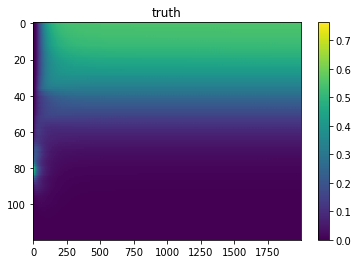

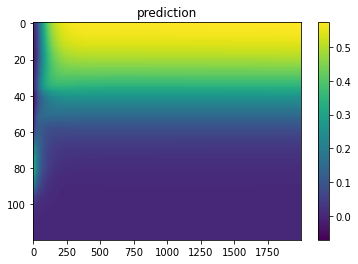

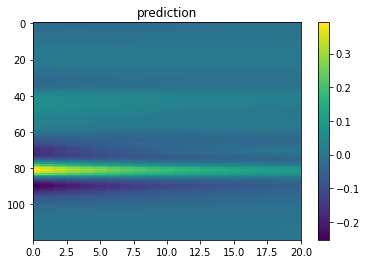

In [21]:

    
model = ELPH_VAR.SVDVAR(runs, rdim=20, n_VAR_steps=5)

model.train(alpha=1e-5, rdim = 5, n_VAR_steps = 5, method='ridge')

model.print_status()


run = runs[7]
testpred = model.predict_single_run(run)

print(model.get_error(run, norm='var2') )

plt.imshow(run, aspect='auto', interpolation='None')
plt.colorbar()
plt.title('truth')
plt.show()

plt.imshow(testpred, aspect='auto', interpolation='None')
plt.colorbar()
plt.title('prediction')
plt.show()

plt.imshow(run-testpred, aspect='auto', interpolation='None')
plt.colorbar()
plt.title('prediction')
plt.xlim(0,20)
plt.show()